## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

['../camera_cal/calibration1.jpg', '../camera_cal/calibration10.jpg', '../camera_cal/calibration11.jpg', '../camera_cal/calibration12.jpg', '../camera_cal/calibration13.jpg', '../camera_cal/calibration14.jpg', '../camera_cal/calibration15.jpg', '../camera_cal/calibration16.jpg', '../camera_cal/calibration17.jpg', '../camera_cal/calibration18.jpg', '../camera_cal/calibration19.jpg', '../camera_cal/calibration2.jpg', '../camera_cal/calibration20.jpg', '../camera_cal/calibration3.jpg', '../camera_cal/calibration4.jpg', '../camera_cal/calibration5.jpg', '../camera_cal/calibration6.jpg', '../camera_cal/calibration7.jpg', '../camera_cal/calibration8.jpg', '../camera_cal/calibration9.jpg']


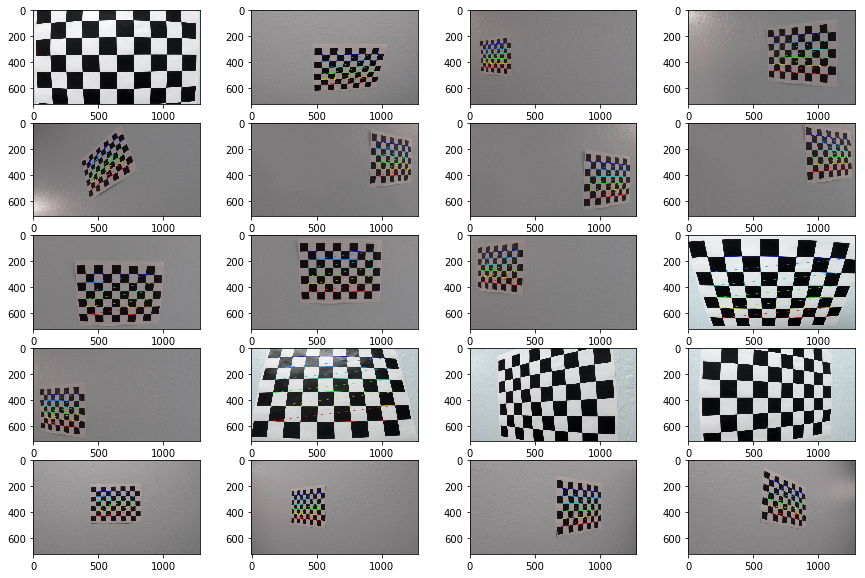

In [241]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from os import listdir

%matplotlib inline 

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
print(images)
#set imgs size
fig = plt.figure(figsize=(15, 10))


#loop all imgs
for num, fname in enumerate(images):
    img = cv2.imread(fname) #read in img
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #grayscale
    ret, corners = cv2.findChessboardCorners(gray_img, (9, 6), None) #find chessboard corners
    #if corners found, get objpoints, imgpoints
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (9, 6), corners, ret) #draw chessboard corners 
    #show all imgs
    fig.add_subplot(5, 4, (num+1))
    plt.imshow(img)   

global objpoints
global imgpoints
plt.show()


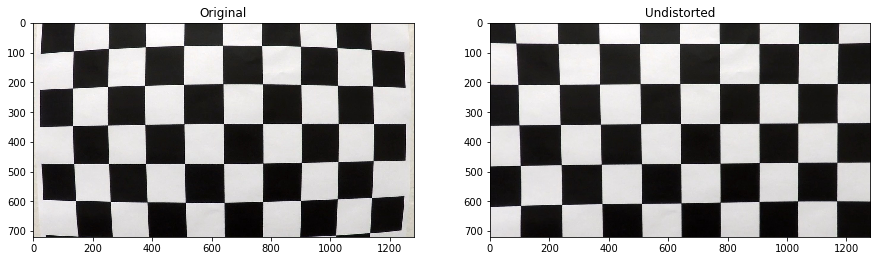

In [174]:
#creat undistort function 
def undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvects, tvects = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
    
#see chessboard test result 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 10))

chess_img = plt.imread(images[0])
chess_undist= undistort(chess_img, objpoints, imgpoints)
ax1.imshow(chess_img)
ax1.set_title('Original')
ax2.imshow(chess_undist)
ax2.set_title('Undistorted')



# example of a distortion-corrected image

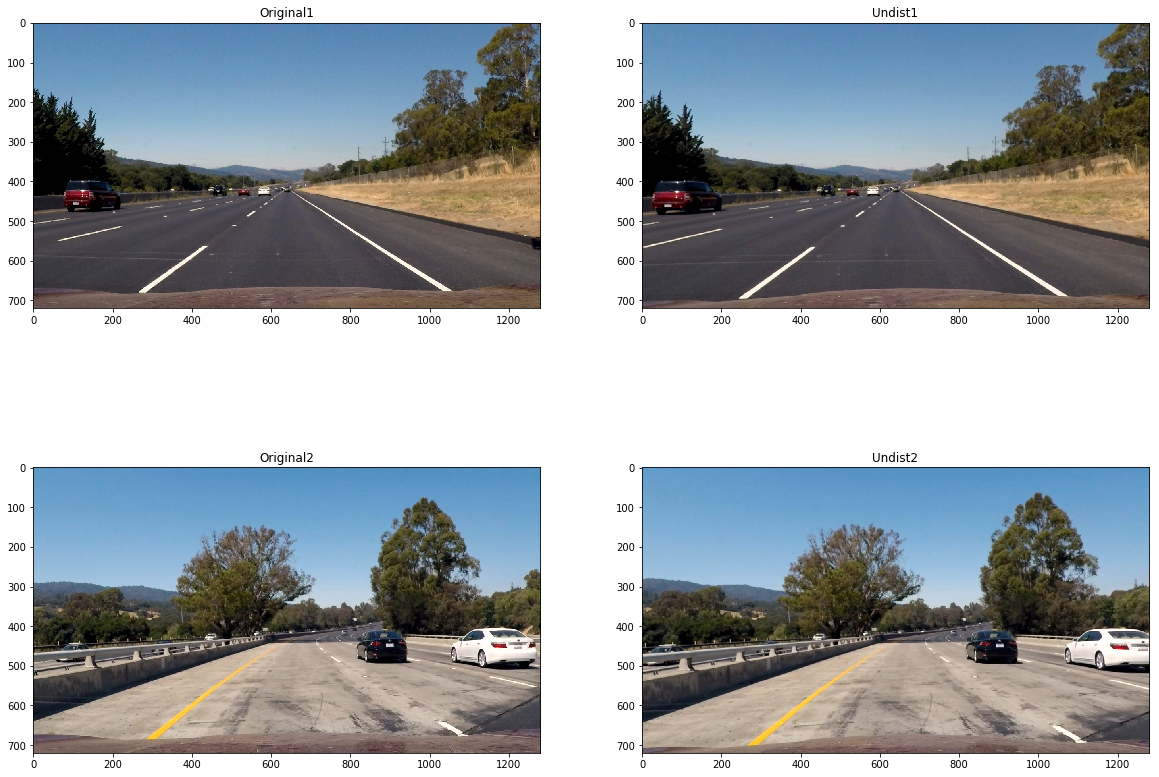

In [348]:
plt.figure(figsize=(20, 15))
#read in road_test_imgs
test_road_imgs = glob.glob('../test_images/*.jpg')
read_test_imgs = []
for img in test_road_imgs:
    read_test_imgs.append(plt.imread(img))

#Examples shown below
test_img1 = read_test_imgs[1]
undist1= undistort(test_img1, objpoints, imgpoints)

test_img2 = read_test_imgs[2]
undist2= undistort(test_img2, objpoints, imgpoints)

test_img3 = read_test_imgs[3]
undist3 = undistort(test_img3, objpoints, imgpoints)
 
plt.subplot(2, 2, 1)
plt.title('Original1')
plt.imshow(test_img1)

plt.subplot(2, 2, 2)
plt.title('Undist1')
plt.imshow(undist1)

plt.subplot(2, 2, 3)
plt.title('Original2')
plt.imshow(test_img2)

plt.subplot(2, 2, 4)
plt.title('Undist2')
plt.imshow(undist2)



# # Perspective Transform

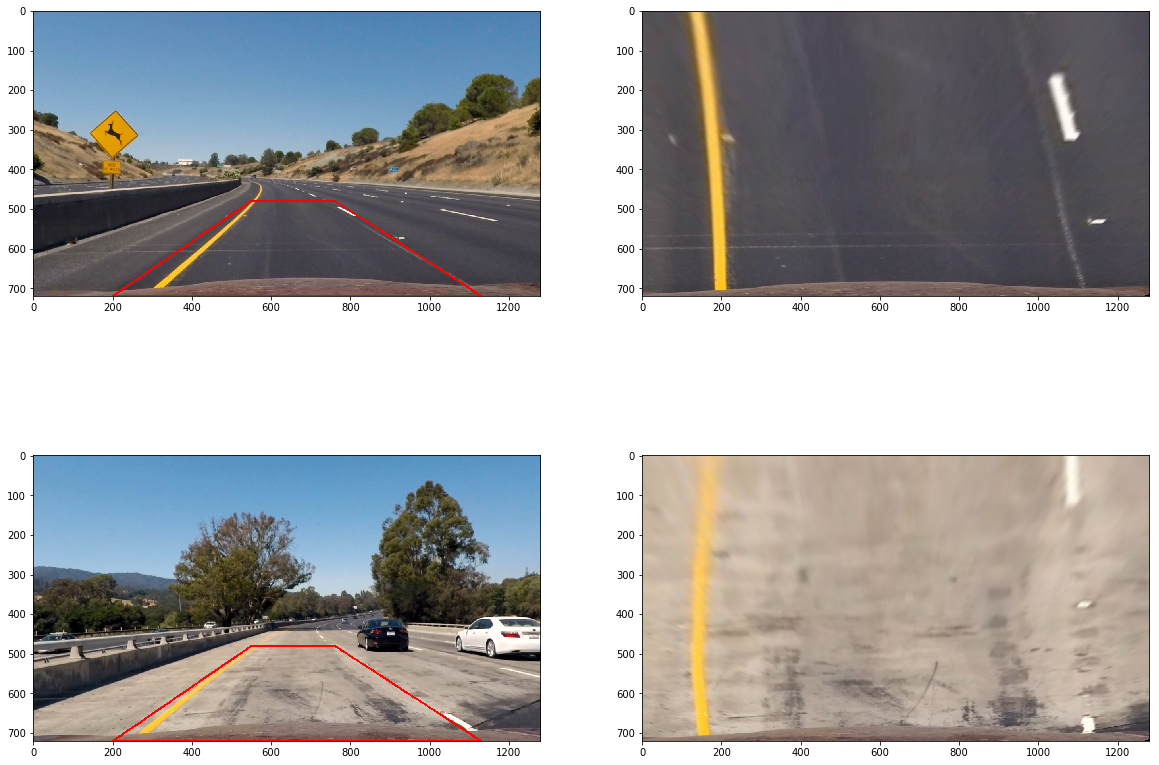

In [270]:
# create a warped function and return a warped_img 
def bird_eye_view(undist_img, dst, src):
    img_size = undist_img.shape[1::-1]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_img = cv2.warpPerspective(undist_img, M, img_size)
    return warped_img, M, Minv

#creat a mask_area function and return the specific area targeted
def mask_area(undist_img):
    #make copy of img
    copy_undist= undist_img.copy()
    
    #use previous un-disotrted img
    #get undist w and h
    undist_shape = undist_img.shape[1::-1]
    
    #left_top and right_top has same y, same for the left_bottom and right_bottom 
    top_y = 480
    bottom_y = undist_shape[1] #720
    
    #get every corner points also get seperated x and y
    left_down = (200, bottom_y)
    left_down_x, left_down_y = left_down
    
    left_top = (550, top_y)
    left_top_x, left_top_y = left_top 
    
    right_top = (undist_shape[0]-520, top_y)
    right_top_x, right_top_y = right_top
    
    right_down = (undist_shape[0]-150, bottom_y)
    right_down_x, right_down_y = right_down
    
    #draw target area
    color = [255, 0, 0]
    cv2.line(copy_undist, left_down, left_top, color, 4)
    cv2.line(copy_undist, left_down, right_down, color, 4)
    cv2.line(copy_undist, left_top, right_top, color, 4)
    cv2.line(copy_undist, right_top, right_down , color, 4)
    
    #src points
    src = np.float32([[left_down_x, left_down_y],  #left_down 
                      [left_top_x, left_top_y],  #left_top
                      [right_top_x, right_top_y],  #right_top
                      [right_down_x, right_down_y]])#right_down
    
    #dst points
    dst = np.float32([[100, undist_shape[1]], #left_down
                      [100, 0], #left_top
                      [1100, 0], #right_top
                      [1100, undist_shape[1]]]) #right_down
    return copy_undist, src, dst 

copy_undist2, src, dst = mask_area(undist2)
copy_undist3, _, _ = mask_area(undist3)
undist_warped2, M, Minv = bird_eye_view(undist2, dst, src)
undist_warped3, _, _= bird_eye_view(undist3, dst, src)

global src
global dst
 
#Example shown below 
plt.figure(figsize =(20, 15))
plt.subplot(2, 2, 1)
plt.imshow(copy_undist3)

plt.subplot(2, 2, 2)
plt.imshow(undist_warped3)

plt.subplot(2, 2, 3)
plt.imshow(copy_undist2)

plt.subplot(2, 2, 4)
plt.imshow(undist_warped2)


# Color and Gradient Threshold 

In [177]:

# create a function -- threshold_xbinary
def threshold_xbinary(img, orient, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #default orient=='x' 
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])]= 1
    return sxbinary

def r_binary(img, thresh):
    r = img[:,:,0]
    rbinary = np.zeros_like(r)
    rbinary[(r >= thresh[0]) & (r <= thresh[1])] =1 
    return rbinary 

def hls_binary(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #get only s here
    s = hls[:,:,2]
    color_binary = np.zeros_like(s)
    color_binary[(s >= thresh[0]) & (s <= thresh[1])]=1
    return color_binary
    
    

def mag_binary(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    magnitude_xy = np.sqrt(sobelx**2 + sobely**2)
    scaled_xy= np.uint8(255*magnitude_xy/np.max(magnitude_xy))
    magnitude_binary = np.zeros_like(magnitude_xy)
    magnitude_binary[(scaled_xy >= thresh[0]) & (scaled_xy <= thresh[1])] =1
    return magnitude_binary 

def dir_binary(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arc = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(arc)
    dir_binary[(arc >= thresh[0]) & (arc <= thresh[1])] = 1
    return dir_binary 

def sobel_combined(image):
    # Apply combined sobel filter
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img_g_mag = mag_binary(image,3,(20,150))
    img_d_mag = dir_binary(image,3,(.6,1.1))
    img_abs_x = threshold_xbinary(image,'x',5,(50,200))
    img_abs_y = threshold_xbinary(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined

def combined_binary(img, threshold_xbinary, sbinary):
    color_binary = np.dstack((np.zeros_like(threshold_xbinary), threshold_xbinary, sbinary))*255
    combined_binary = np.zeros_like(threshold_xbinary)
    combined_binary[(threshold_xbinary==1) | (sbinary==1)]=1
    return combined_binary


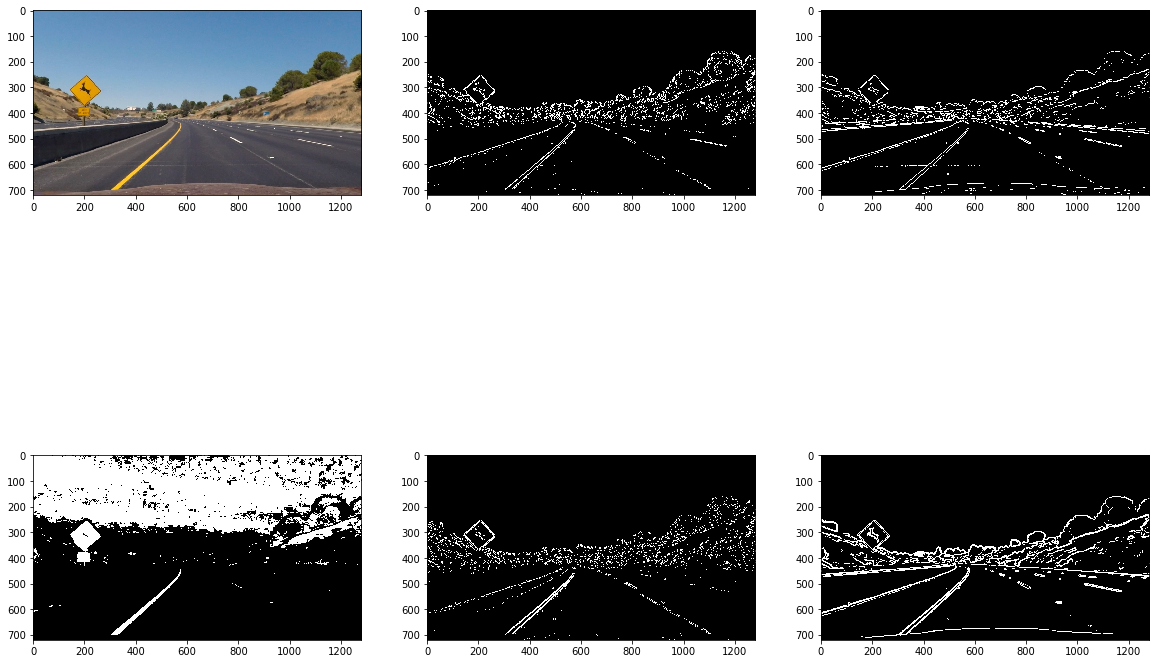

In [271]:
hls = hls_binary(undist3, thresh=(100, 255))
sxbinary = threshold_xbinary(undist3, orient = 'x', sobel_kernel =3, thresh=(20, 100))
sybinary = threshold_xbinary(undist3, orient ='y', sobel_kernel =3, thresh = (30, 200))
dirbinary = dir_binary(undist3, sobel_kernel =3, thresh=(0.9, np.pi/2))
mag = mag_binary(undist3, sobel_kernel = 15, thresh = (50, 200))
sobel_comb = sobel_combined(undist3)

fig = plt.figure(figsize =(20, 15))
#1
ax1 = fig.add_subplot(2, 3, 1)
ax1.imshow(undist3)
#2
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(sxbinary, cmap='gray')
#3
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(sybinary, cmap='gray')
#4
ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(hls, cmap='gray')
#5
ax5 = fig.add_subplot(2, 3, 5)
ax5.imshow(sobel_comb, cmap='gray')
#6
ax6 = fig.add_subplot(2, 3, 6)
ax6.imshow(mag, cmap='gray')

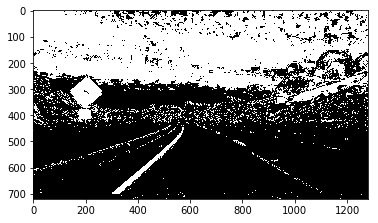

In [272]:
#binary_combo_example
combined1 = combined_binary(undist3, hls, sobel_comb)
plt.imshow(combined1, cmap = 'gray')


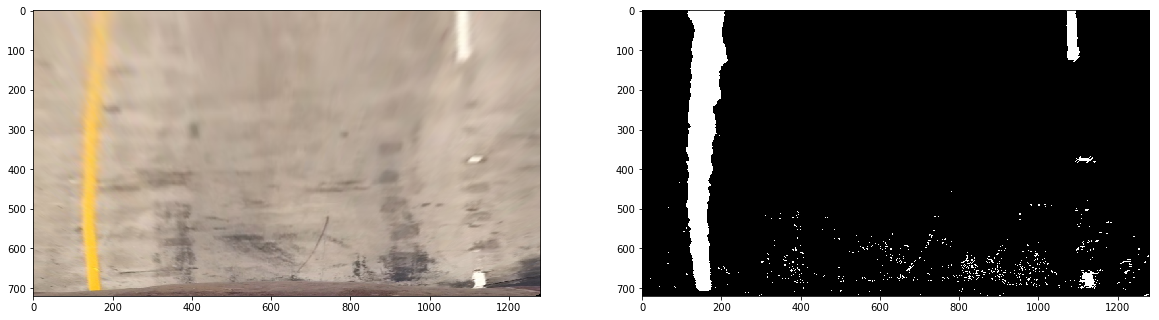

In [273]:
#apply combination to bird eye view
def binary_warped(undist_img):
    warped_img, _, _ = bird_eye_view(undist_img, dst, src)
    hls = hls_binary(warped_img, thresh=(100, 255))
    sobel_comb = sobel_combined(warped_img)
    binary_warped_img = combined_binary(warped_img, hls, sobel_comb)
    return binary_warped_img

binary_warped2 = binary_warped(undist2)
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize =(20, 15))
ax1.imshow(undist_warped2)
ax2.imshow(binary_warped2, cmap='gray')

# Lane Line Detection

640


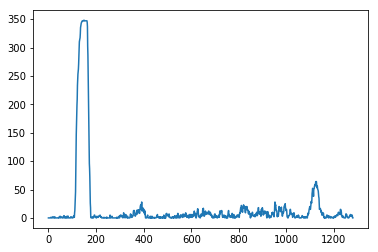

In [274]:
#find midpoint of two lane lines
histogram = np.sum(binary_warped2[binary_warped2.shape[0]//2:,:], axis = 0)
midpoint = np.int(histogram.shape[0]//2)
print(midpoint)
plt.plot(histogram)

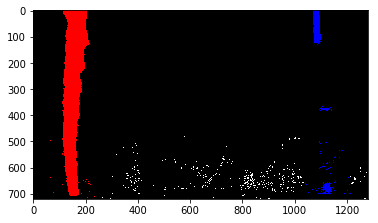

In [298]:
def lane_finding(warped_img):
    histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis = 0)
    midpoint = np.int(histogram.shape[0]//2)
    left_xbase = np.argmax(histogram[:midpoint])
    right_xbase = np.argmax(histogram[midpoint:]) +midpoint
    out_img = np.dstack((warped_img, warped_img, warped_img))*255

    nwindows = 9
    window_height = np.int(warped_img.shape[0]//nwindows)
    
    nonzero = warped_img.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]

    left_xcurrent = left_xbase
    right_xcurrent = right_xbase
    
    margin = 90
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_ylow = warped_img.shape[0]-(window+1)*window_height
        win_yhigh = warped_img.shape[0]-window*window_height
        win_xleft_low = left_xcurrent - margin
        win_xleft_high = left_xcurrent + margin
        win_xright_low = right_xcurrent - margin
        win_xright_high = right_xcurrent + margin
        
        #cv2.rectangle(out_img, (win_xleft_low, win_ylow), (win_xleft_high, win_yhigh), (0, 255, 0), 2)
        #cv2.rectangle(out_img, (win_xright_low, win_ylow), (win_xright_high, win_yhigh), (0, 255, 0), 2)
        
        good_left_inds = ((nonzeroy >= win_ylow) & (nonzeroy < win_yhigh) & (nonzerox >= win_xleft_low)
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_ylow) & (nonzeroy < win_yhigh) & (nonzerox >= win_xright_low) 
                           & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            left_xcurrent = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            right_xcurrent = np.int(np.mean(nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #extract the inds    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #fit left/right to the second polynomial
    if len(leftx) == 0:
        left_fit = []
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) == []:
        right_fit = []
    else:
        right_fit = np.polyfit(righty, rightx, 2)
        
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds

out_img, left_fit, right_fit, left_lane_inds, right_lane_inds= lane_finding(binary_warped2)

#visualize color fit line 
plt.imshow(out_img)

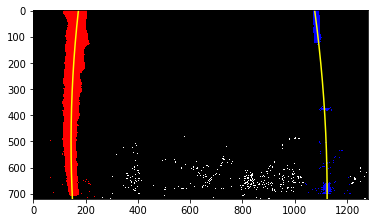

In [282]:
#draw yellow line 
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0]) 
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
plt.plot(left_fitx, ploty, color = 'yellow')
plt.plot(right_fitx, ploty, color = 'yellow')
plt.imshow(out_img)

In [294]:
def next_frame_finding(next_warped_img, left_fit, right_fit):
    #get nonzero
    nonzero = next_warped_img.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    
    margin = 100
    #create a img to draw 
   
    out_img = np.dstack((next_warped_img, next_warped_img, next_warped_img))*255
    #window_img = np.zeros_like(out_img)
    
    left_lane_inds = ((nonzerox > (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]-margin)) & 
                      (nonzerox < (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy +left_fit[2] +margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                      (nonzerox < (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] +margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx)==0:
        continue_left_fit ==[]
    else:
        continue_left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) == 0:
        continue_right_fit ==[]
    else:
        continue_right_fit = np.polyfit(righty, rightx, 2)
    return continue_left_fit, continue_right_fit, left_lane_inds, right_lane_inds

In [315]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def curvature(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curve = ((1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**1.5)/np.abs(2*left_fit_cr[0])
    right_curve = ((1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**1.5)/np.abs(2*right_fit_cr[0])
    
    #car position in the middle of img
    car_position = binary_warped.shape[1]/2
    #calculate left and right bottom, center curvature is half of the sum
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[1]*y_eval + right_fit[2]
    center_position = (left_lane_bottom + right_lane_bottom) /2.
    center_locate = (car_position-center_position)*xm_per_pix
    return center_locate, left_curve, right_curve

#example
center_location, left_curve, right_curve= curvature(binary_warped2, left_fit, right_fit, left_lane_inds, right_lane_inds)
print(center_location, left_curve, right_curve)

0.0380278170995 1484.70467403 1726.28898016


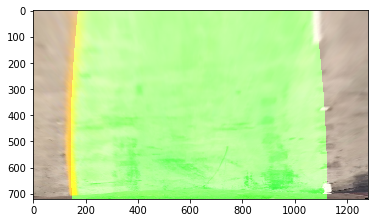

In [304]:
def path_visualize(undist_img, binary_warped, left_fit, right_fit):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    ploty = np.linspace (0, binary_warped.shape[0]-1, binary_warped.shape[0])
    #parabolas
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx =right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line_window, right_line_window))
    
    cv2.fillPoly(window_img, np.int_([line_pts]), (0, 255, 0))
    result = cv2.addWeighted(undist_img, 1 , window_img, 0.7, 0) 
    return result
next_left_fit, next_right_fit, next_left_inds, next_right_inds = next_frame_finding(undist_warped2, left_fit, right_fit)
res = path_visualize(undist_warped2, binary_warped2, next_left_fit, next_right_fit)
plt.imshow(res)

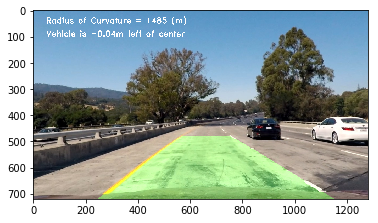

In [316]:
#draw and warp back to original image
def draw_back_original(binary_warped, undist, left_fitx, right_fitx, to_center, left_curve, right_curve):
    #create a blank img
    warped_zero = np.zeros_like(binary_warped).astype(np.uint8)
    #create a color img
    color_out = np.dstack((warped_zero, warped_zero, warped_zero))
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_out, np.int_([pts]), (0, 255, 0))
    
    #warped back to original undist img
    newwarp = cv2.warpPerspective(color_out, Minv, (undist.shape[1], undist.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #get direction to left or right
    if to_center < 0:
        position = 'left'
        curvature = left_curve
    else:
        position = 'right'
        curvature = right_curve
    #visualize in warped back img 
    cv2.putText(result, 'Radius of Curvature = {:.0f} (m)'.format(curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Vehicle is {:.2f}m {} of center'.format(to_center, position), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    return result

#example
result = draw_back_original(binary_warped2, undist2, left_fitx, right_fitx, to_center, left_curve, right_curve)
plt.imshow(result)

In [323]:
class Lane():
    def __init__(self):
        self.last_left = None
        self.last_right = None
        self.left_fit = None
        self.right_fit = None
        self.counter = 0
        
def check_slope(left_fit, right_fit):
    if len(left_fit)==0 or len(right_fit)== 0:
        status = False
    else:
        left_slope1 = 2*left_fit[0]*720 + left_fit[1]
        right_slope1 = 2*right_fit[0]*720 + right_fit[1]
        diff1 = np.abs(left_slope1 - right_slope1)
        
        left_slope2 = 2*left_fit[0]*360 + left_fit[1]
        right_slope2 = 2*right_fit[0]*360 + right_fit[1]
        diff2 = np.abs(left_slope2 - right_slope2)
        
        if diff1 <= 0.55 and diff2 <= 0.55:
            status = True
        else:
            status = False
        
    return status
        

In [349]:
lane = Lane()

def process_img(img):
    undist_img = undistort(img, objpoints, imgpoints)
    binary_warped_img = binary_warped(undist_img) 
    if lane.counter == 0:
        out_img, lane.left_fit, lane.right_fit, left_lane_inds, right_lane_inds = lane_finding(binary_warped_img)
    else:
        lane.left_fit, lane.right_fit, left_lane_inds, right_lane_inds = next_frame_finding(binary_warped_img, lane.left_fit, lane.right_fit)
        
    status = check_slope(lane.left_fit, lane.right_fit)
    if status == True:
        lane.last_left, lane.last_right = lane.left_fit, lane.right_fit
        lane.counter += 1
    else:
        lane.left_fit, lane_right_fit = lane.last_left, lane.last_right
    
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0]) 
    left_fitx = lane.left_fit[0]*ploty**2 + lane.left_fit[1]*ploty + lane.left_fit[2]
    right_fitx = lane.right_fit[0]*ploty**2 + lane.right_fit[1]*ploty + lane.right_fit[2]
     
    center_location, left_curve, right_curve = curvature(binary_warped_img, lane.left_fit, lane.right_fit, left_lane_inds, right_lane_inds)
    result = draw_back_original(binary_warped_img, undist_img,left_fitx, right_fitx, center_location, left_curve, right_curve)       
    return result 

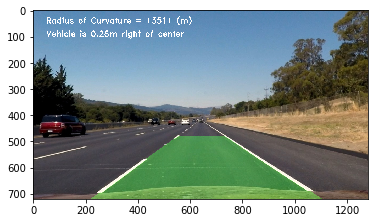

In [350]:
res = process_img(read_test_imgs[1])
plt.imshow(res)

In [366]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML



In [365]:
output = 'road.mp4'

from moviepy.editor import ImageSequenceClip
clip1 = VideoFileClip('../project_video.mp4')
new_frames = []


    
# %time new_frames = [process_img(fr) for fr in clip1.iter_frames()]
print('processing')
new_clip = clip1.fl_image(process_img)

print('images done processing')
    
    
# new_clip = ImageSequenceClip(new_frames, fps=clip1.fps)
%time new_clip.write_videofile(output, audio=False)
    

HTML("""
<video width="960" height="540" controls>
  <source src='{0}'>
</video>
""".format(output))

processing
images done processing
[MoviePy] >>>> Building video road.mp4
[MoviePy] Writing video road.mp4



100%|█████████▉| 1260/1261 [27:16<00:01,  1.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: road.mp4 

CPU times: user 25min 37s, sys: 2min 15s, total: 27min 52s
Wall time: 27min 17s
